## Optimization demo with Scipy

In [1]:
import numpy 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import scipy.optimize

### Optimization Methods
- Grid Search
- Random Search
- Powell (local search)
- Nelder-Mead (local search)
- Basin Hopping
- Differential Evolution

#### Define Objective function

In [2]:
class Objective(object):
    """The Objective function to maximize.
    
    Replace with any function or time consuming and expensive process.
    """
    
    def __init__(self):
        self.parameters = [
            {'name': 'x1',
             'type': 'double',
             'bounds': { 'min': -70.0, 'max': 70.0 },
            },
            {'name': 'x2',
             'type': 'double',
             'bounds': { 'min': -70.0, 'max': 70.0 },
            },
        ]
        self.plotting_bounds = {'min': -250, 'max': 250}

    @staticmethod
    def evaluate(params):
        """Returns the results of our objective function given a dict of parameters."""
        # EggHolder function - http://www.sfu.ca/~ssurjano/egg.html
        return -(params['x2'] + 47) * \
            numpy.sin(numpy.sqrt(abs(params['x2'] + params['x1'] / 2 + 47))) - \
            params['x1'] * numpy.sin(numpy.sqrt(abs(params['x1'] - (params['x2'] + 47))))
    
    def within_bounds(self, params):
        return all(((
            param['bounds']['min'] < params[param['name']] < param['bounds']['max']
            for param
            in self.parameters
        )))
    
obj = Objective()

#### Plotter function

In [3]:
def plot_obj_func(obj, res=64, history=None):
    x = numpy.linspace(
        obj.parameters[0]['bounds']['min'],
        obj.parameters[0]['bounds']['max'],
        res,
    )
    y = numpy.linspace(
        obj.parameters[1]['bounds']['min'],
        obj.parameters[1]['bounds']['max'],
        res,
    )
    X, Y = numpy.meshgrid(x, y)
    Z = numpy.zeros((res, res))
    
    for i, p1 in enumerate(x):
        for j, p2 in enumerate(y):
            params = {
                obj.parameters[0]['name']: p1,
                obj.parameters[1]['name']: p2,
            }
            Z[j][i] = obj.evaluate(params)
            
    '''3d-plot'''
    fig = plt.figure(figsize=(24, 7))
    ax_3d = fig.add_subplot(131, projection='3d')
    ax_3d.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    
    '''contor-plot'''
    ax_contour = fig.add_subplot(132)
    ax_contour.contour(X, Y, Z)
    ax_contour.set_xlabel(obj.parameters[0]['name'])
    ax_contour.set_ylabel(obj.parameters[1]['name'])
  
    best_so_far = -numpy.inf
    best_hist = []
    true_val = []
    
    if history is not None:
        for params in history:
            obj_value = obj.evaluate(params)
            if obj_value > best_so_far:
                best_so_far = obj_value
            best_hist.append(best_so_far)
            true_val.append(obj_value)
            
            xval = params[obj.parameters[0]['name']]
            yval = params[obj.parameters[1]['name']]
            
            ax_3d.plot([xval], [yval], obj.evaluate(params), 'k*')
            ax_contour.plot([xval], [yval], 'k*')
            
    '''scatter-plot'''
    ax_best = fig.add_subplot(133)
    ax_best.plot(best_hist, 'bo--')
    ax_best.plot(true_val, 'b*')
    ax_best.set_ylim(
        obj.plotting_bounds['min'],
        obj.plotting_bounds['max']
    )
    ax_best.set_xlabel("Number of Evaluations")
    ax_best.set_ylabel("Best Value Observed")

    plt.show()    
    
    print("Best value found: {0}".format(best_so_far))
    return best_hist

total_hist = {}

### Implement Scipy

In [4]:
def scipy_opt(obj, method=None, x0=[0,0]):

    scipy_history = []

    def scipy_obj_func_wrapper(x):     
        params = {
            obj.parameters[0]['name']: x[0],
            obj.parameters[1]['name']: x[1],
        }
        
        if not obj.within_bounds(params):
            return 1e8
        
        scipy_history.append(params)
        # scipy wants to minimize
        return -obj.evaluate(params)

    scipy.optimize.minimize(scipy_obj_func_wrapper, x0, method=method)

    return(scipy_history)

#### 1. Powell

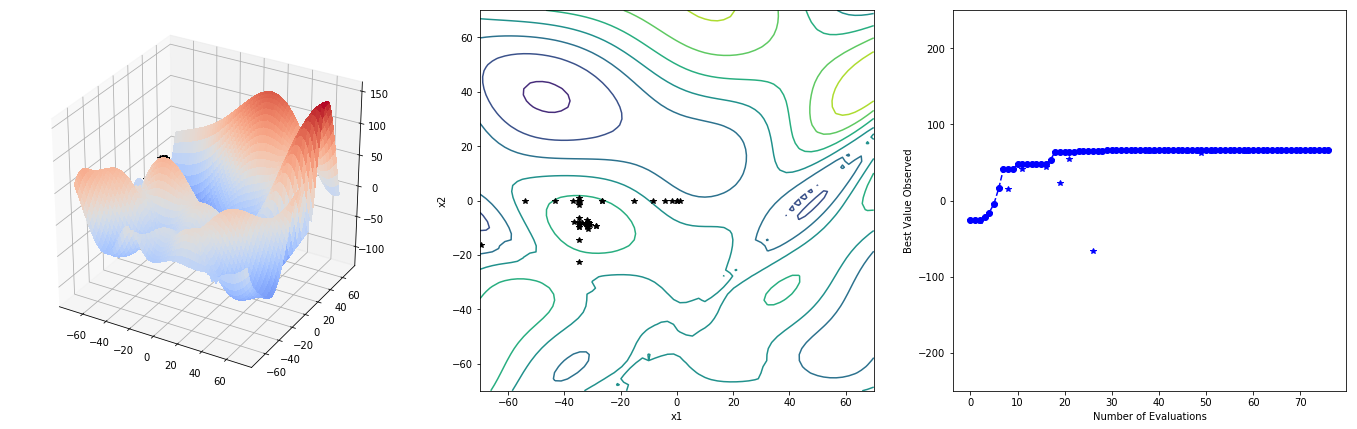

Best value found: 65.91403901661809


In [5]:
total_hist['Powell'] = plot_obj_func(obj, history=scipy_opt(obj, method='Powell'))

#### 2. Nelder Mead

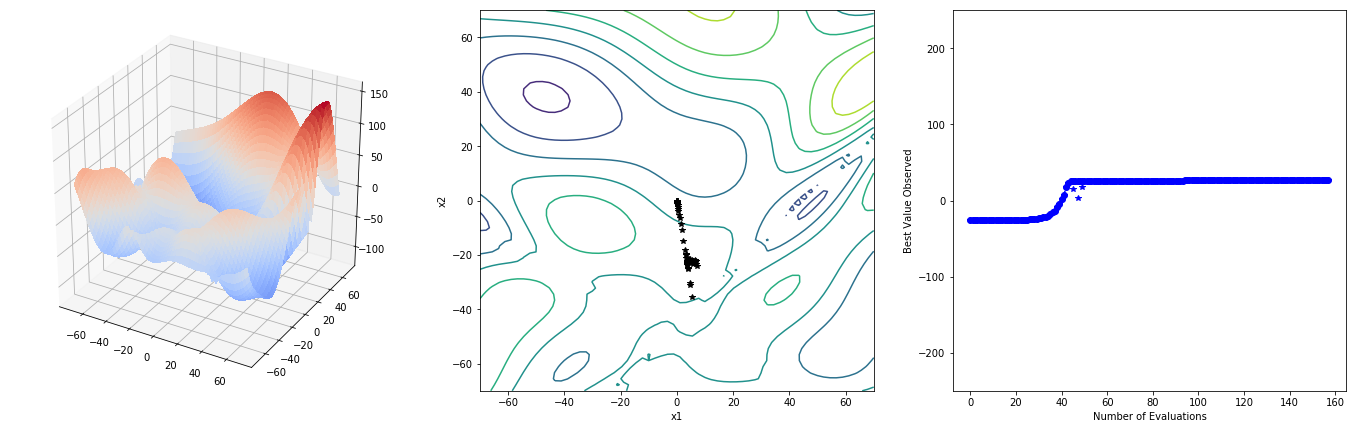

Best value found: 26.6249361557555


In [6]:
total_hist['Nelder-Mead'] = plot_obj_func(obj, history=scipy_opt(obj, method='Nelder-Mead'))

#### 3.Basin Hopping

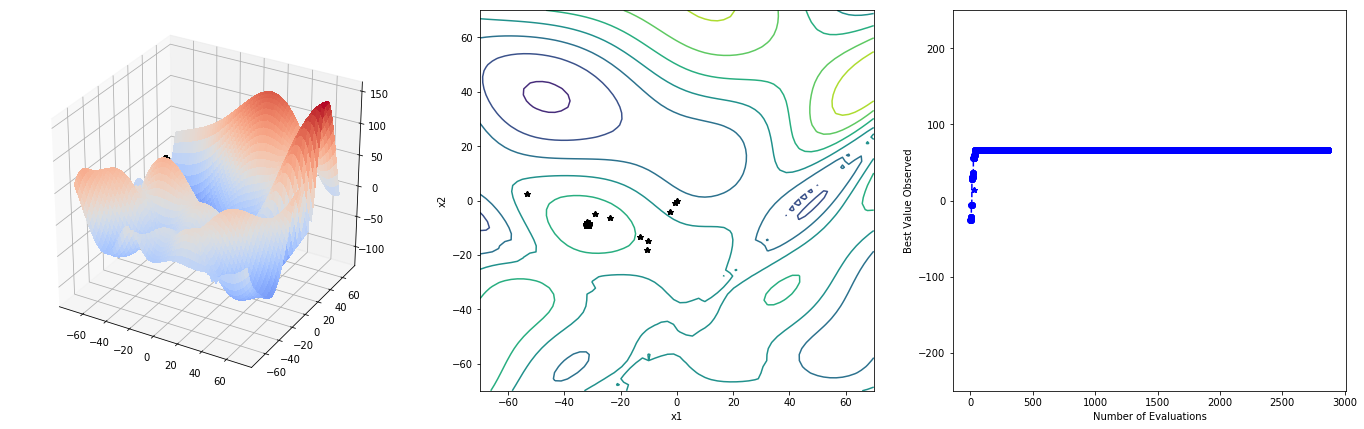

Best value found: 65.91403901664063


In [7]:
basinhopping_history = []

def scipy_obj_func_wrapper(x):     
    params = {
        obj.parameters[0]['name']: x[0],
        obj.parameters[1]['name']: x[1],
    }

    if not obj.within_bounds(params):
        return 1e8

    basinhopping_history.append(params)
    # scipy wants to minimize
    return -obj.evaluate(params)

scipy.optimize.basinhopping(scipy_obj_func_wrapper, [0, 0])

total_hist['basinhopping'] = plot_obj_func(obj, history=basinhopping_history)

#### 4. Differential Evolution

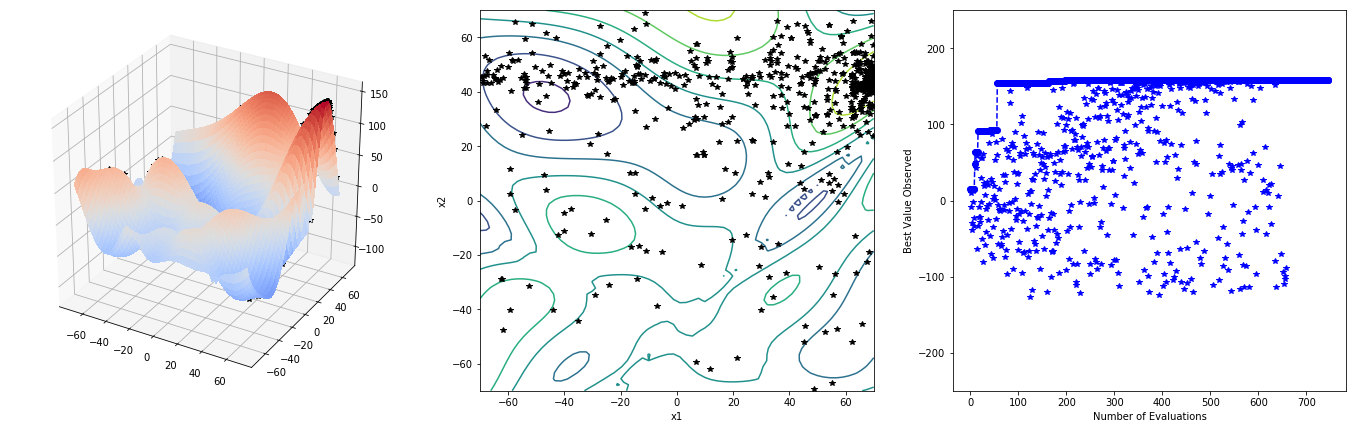

Best value found: 158.55506846546527


In [8]:

differential_evolution_history = []

def scipy_obj_func_wrapper(x):     
    params = {
        obj.parameters[0]['name']: x[0],
        obj.parameters[1]['name']: x[1],
    }

    if not obj.within_bounds(params):
        return 1e8

    differential_evolution_history.append(params)
    # scipy wants to minimize
    return -obj.evaluate(params)

scipy.optimize.differential_evolution(scipy_obj_func_wrapper, [
        (
            obj.parameters[0]['bounds']['min'],
            obj.parameters[0]['bounds']['max'],
        ),
        (
            obj.parameters[1]['bounds']['min'],
            obj.parameters[1]['bounds']['max'],
        ),
    ])

total_hist['differential_evolution'] = plot_obj_func(obj, history=differential_evolution_history)

### Comperision

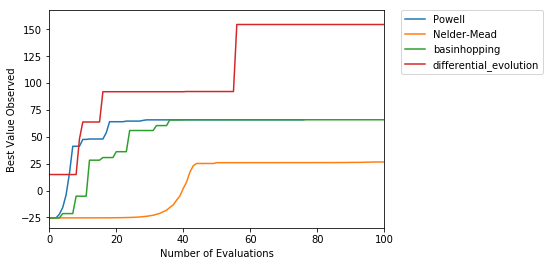

In [9]:
def plot_total_hist():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for opt_name, history in total_hist.items():
        ax.plot(history, label=opt_name)
        
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlim(0,100)
    ax.set_xlabel("Number of Evaluations")
    ax.set_ylabel("Best Value Observed")

plot_total_hist()